# Solving the wave equation with a PINN

We aim to solve the simple 1D wave equation:

$$
\frac{\partial^2 u}{\partial t^2} = c^2 \frac{\partial^2 u}{\partial x^2}
$$

This equation can be solved analytically using separation of variables, but we aim to solve it numerically with a PINN, and check that our solution is a sinusoidal wave. To do this, we need the initial conditions:

$$
u(0, t) = u(1, t) = u(x, 0) = u(x, 1) = 1
$$

## Theory

The wave equation can be written in the form $F(x, t) = 0$, where:

$$
F(x, t) = \frac{\partial^2 u}{\partial t^2} - c^2 \frac{\partial^2 u}{\partial x^2}
$$

We want the neural network to learn the solution $u(x, t)$, so we make a general model `model(param, x, t)` that should converge to $u(x, t)$ after training. Thus, given our wave equation, we can define a custom loss function $L(a, x, t)$, where $a$ denotes the matrix of weights and biases:

$$
L(a, x, t) = \frac{1}{n} \sum_{i=0}^n \left( \| F(x, t) \|^2 - \| u(x, t) - z \|^2 \right)
$$

Where $z$ denotes the initial conditions we give to the model. Thus, through the same method of gradient descent, the neural network learns the function $u(x, t)$:

$$
a_{n + 1} = a_n - \gamma \nabla L(a, x, t)
$$

In [105]:
import jax
import jax.numpy as jnp
from jax import jit, grad, vmap
import matplotlib.pyplot as plt

In [168]:
def sigmoid(x):
    return 1.0 / (1.0 + jnp.exp(-x))

In [180]:
# Model with basic sigmoid activation to represent u(x, t)
def model(params, x, t, activation=sigmoid):
    wx = params[:100] # x weights
    wt = params[100:200] # t weights
    b0 = params[200:300]
    w1 = params[300:400]
    b1 = params[400]
    h = activation(x*wx + t*wt + b0) # we first create a typical neuron
    o = jnp.sum(h*w1) + b1 # then we sum the neuron output as u(x, t) is a scalar-valued function
    return o

In [181]:
df_2dx_2 = grad(grad(model, 2), 2) # ∂^2f / ∂x^2
df_2dt_2 = grad(grad(model, 1), 1) # ∂^2f / ∂t^2

In [192]:
model_vect = vmap(model, (None, 0, 0))
df_2dx_2_vect = vmap(df_2dx_2, (None, 0, 0))
df_2dt_2_vect = vmap(df_2dt_2, (None, 0, 0))

In [193]:
# The PDE (what we refer to as F(x, t))
def pde(params, x, t, c=1):
    # ∂^2f / ∂t^2 - c^2 (∂^2f / ∂x^2)
    return df_2dx_2_vect(params, x, t) - \
        c ** 2 * df_2dt_2_vect(params, x, t)

In [202]:
def loss(params, x, t, bc=1):
    return jnp.mean(pde(params, x, t, bc) ** 2 + (model(params, 0, 0) - bc) ** 2)

In [203]:
loss_grad = grad(loss, 0)

In [204]:
key = jax.random.PRNGKey(0)

In [205]:
epochs = 5000
lr = 0.0005

In [206]:
params = jax.random.normal(key, shape=(401,))

In [207]:
samples = 120

In [208]:
x = jnp.linspace(0, 4 * jnp.pi, samples)
t = jnp.linspace(0, 1, samples)

In [209]:
for epoch in range(epochs):
    if epoch % 100  == 0:
        print(f"Epoch: {epoch} loss: {loss(params, x, t)}")
    gradient = loss_grad(params, x, t)
    params -= lr * gradient

Epoch: 0 loss: 3.8312644958496094
Epoch: 100 loss: 0.2205786257982254
Epoch: 200 loss: 0.13671687245368958
Epoch: 300 loss: 0.09569057077169418
Epoch: 400 loss: 0.06984631717205048
Epoch: 500 loss: 0.05255179852247238
Epoch: 600 loss: 0.040670353919267654
Epoch: 700 loss: 0.03238330036401749
Epoch: 800 loss: 0.026540342718362808
Epoch: 900 loss: 0.022380810230970383
Epoch: 1000 loss: 0.019388848915696144
Epoch: 1100 loss: 0.017209568992257118
Epoch: 1200 loss: 0.01559792086482048
Epoch: 1300 loss: 0.014384252019226551
Epoch: 1400 loss: 0.01345145795494318
Epoch: 1500 loss: 0.012718705460429192
Epoch: 1600 loss: 0.012130025774240494
Epoch: 1700 loss: 0.011646967381238937
Epoch: 1800 loss: 0.011242669075727463
Epoch: 1900 loss: 0.010898327454924583
Epoch: 2000 loss: 0.01060058269649744
Epoch: 2100 loss: 0.010339619591832161
Epoch: 2200 loss: 0.010108483955264091
Epoch: 2300 loss: 0.009901825338602066
Epoch: 2400 loss: 0.009715796448290348
Epoch: 2500 loss: 0.009546903893351555
Epoch: 260

In [210]:
t0 = jnp.zeros(samples)

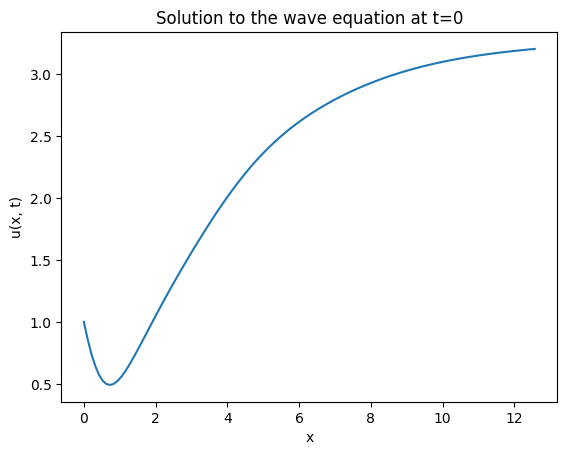

In [212]:
# Plotting the solution at t=0
plt.plot(x, model_vect(params, x, t0))
plt.title("Solution to the wave equation at t=0")
plt.xlabel("x")
plt.ylabel("u(x, t)")
plt.show()

In [213]:
t1 = jnp.ones(samples)

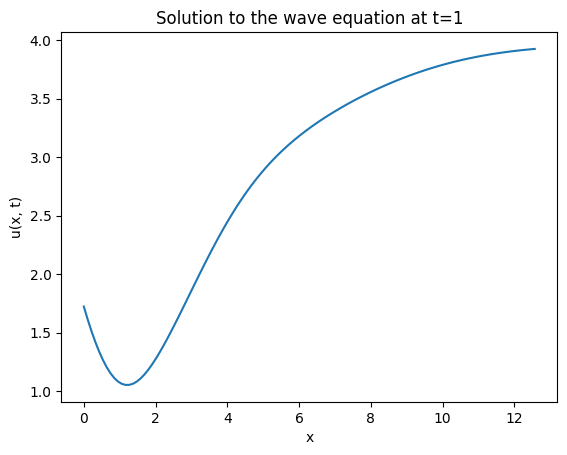

In [214]:
# Plotting the solution at t=1
plt.plot(x, model_vect(params, x, t1))
plt.title("Solution to the wave equation at t=1")
plt.xlabel("x")
plt.ylabel("u(x, t)")
plt.show()